In [199]:
from datetime import datetime, timezone

from client.kalshi_client import AuthedApiInstance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression
from kalshi_python import Market
import yfinance as yf

# set seaborn style
sns.set_theme()
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (12,6)

In [182]:
kalshi_api = AuthedApiInstance()

### Compute Kalshi Forecasts and Historical Surprise

In [183]:
@dataclass
class CPIRelease:
    """
    Create a single dataclass to store information about a particular CPI release.

    Kalshi markets are individual binaries, of the form:
    "Will CPI growth be >0.5% in February?"

    That means we need to consider the pricing of several individual markets,
    with different strikes, to compute the market conensus for a pariticular month.
    """

    close_date: datetime
    true_cpi_value: float
    markets: list[Market]

    def target(self, market: Market) -> float:
        if market.floor_strike is None:
            return float(market.subtitle.replace(">", "").replace("%", "")) + 0.1
        else:
            return market.floor_strike + 0.1

    def kalshi_conensus(self) -> float:
        sorted_markets = sorted(self.markets, key=lambda x: self.target(x))

        conensus = 0
        accounted_probability = 0
        for market in reversed(sorted_markets):
            # Filter out illiquid markets
            if market.yes_ask - market.yes_bid > 10:
                continue
            probability = (market.yes_ask + market.yes_bid) / 2
            unaccounted_probability = max(0, probability - accounted_probability)

            target = self.target(market)
            conensus += target * unaccounted_probability / 100
            accounted_probability += unaccounted_probability

        if accounted_probability < 1:
            conensus /= accounted_probability

        return conensus

In [206]:
# Get summary statistics
series_ticker = 'CPI'

markets_in_series = kalshi_api.get_markets(series_ticker=series_ticker, limit=1000).markets

cpi_releases_by_ticker = {}

for market in markets_in_series:
    event_ticker = market.event_ticker

    if "CPI-" not in event_ticker:
        continue
    if event_ticker not in cpi_releases_by_ticker:
        close_date = datetime.fromisoformat(market.close_time)
        true_cpi_value = float(market.expiration_value.replace("%", "")) if market.expiration_value != "" else None

        cpi_releases_by_ticker[event_ticker] = CPIRelease(close_date, true_cpi_value, [])

    cpi_releases_by_ticker[event_ticker].markets.append(market)

### Compare to SPX Movements

In [207]:
spx_prices = yf.Ticker("^NDX").history(start="2022-01-01", end=datetime.now().strftime("%Y-%m-%d"), interval="1h")
spx_prices.index = pd.to_datetime(spx_prices.index)
spx_prices["Delta"] = spx_prices["Close"] - spx_prices["Open"]

In [208]:
kalshi_surprise = []
spx_change = []

for ticker, cpi_release in cpi_releases_by_ticker.items():
    if_future =cpi_release.close_date > datetime.now().astimezone(timezone.utc)
    if_recent = cpi_release.close_date >= datetime(2022, 6, 1, tzinfo=timezone.utc)
    if if_future or not if_recent:
        continue

    last_point = spx_prices[spx_prices.index < cpi_release.close_date].iloc[-1]
    next_point = spx_prices[spx_prices.index >= cpi_release.close_date].iloc[0]

    kalshi_surprise.append(cpi_release.true_cpi_value - cpi_release.kalshi_conensus())
    spx_change.append(next_point["Open"] - last_point["Close"])

surprise_vs_spx = pd.DataFrame({"CPI surprise (actual - predicted)": kalshi_surprise, "SPX change": spx_change})

<Axes: xlabel='CPI surprise (actual - predicted)', ylabel='SPX change'>

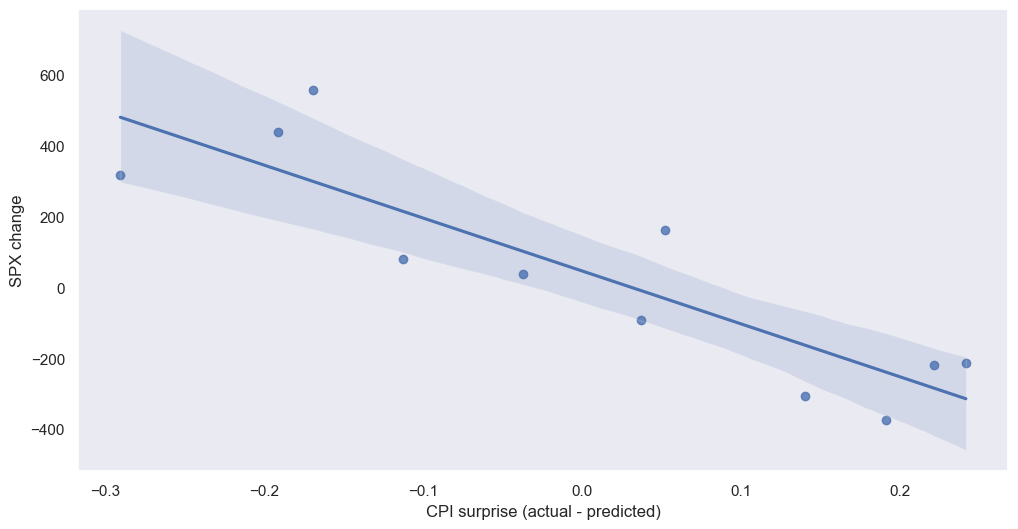

In [209]:
sns.regplot(data=surprise_vs_spx, x="CPI surprise (actual - predicted)", y="SPX change")

In [217]:
surprise_to_spx = LinearRegression().fit(np.array(kalshi_surprise).reshape(-1, 1), spx_change)

# Check r^2 correlation - the closer this is to one, the better
# indicator Kalshi surprise is of SPX change
np.corrcoef(kalshi_surprise, spx_change, 1)[0, 1] ** 2

0.7666665606385146

### SPX Calculator

In [241]:
def predicted_spx_change(cpi_forecast_for_next_release: float) -> float:
    """
    Given a CPI forecast for the next release, predict the SPX change
    """

    future_cpi_releases = [r for r in cpi_releases_by_ticker.values() if r.close_date > datetime.now().astimezone(timezone.utc)]
    next_cpi_release = sorted(future_cpi_releases, key=lambda x: x.close_date)[0]

    kalshi_surprise = cpi_forecast_for_next_release - next_cpi_release.kalshi_conensus()
    expected_change = surprise_to_spx.predict([[kalshi_surprise]])

    print(f"""Your forecast implies market surprise of {kalshi_surprise:.2f}%. Using the regression shown above,
              this would cause the SPX to move by approximately {expected_change[0]:.0f}.""")

In [243]:
# 0.5% is passed as an example, but you can pass whatever
# you think the next CPI release will be
predicted_spx_change(0.5)

Your forecast implies market surprise of 0.02%. Using the regression shown above,
              this would cause the SPX to move by approximately 22.
